In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imgLoader as ld
from drawMap import drawMapGrid

%load_ext autoreload
%autoreload 2

OUTPUT_IMG_SIZE = [3600, 1800]

PLANET_RADIUS = 260
OM_RAD = 380.53
OM = [None, 
      [0, 0, +OM_RAD], 
      [0, 0, -OM_RAD], 
      [0, +OM_RAD, 0],
      [0, -OM_RAD, 0], 
      [+OM_RAD, 0, 0], 
      [-OM_RAD, 0, 0]]

PATH = "./images/"

# Input Image

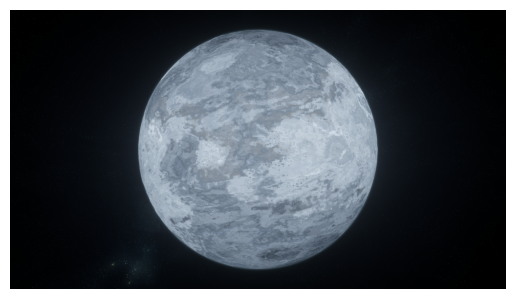

{
    "dim": [
        3840,
        2160
    ],
    "distance": {
        "om1": 593.7,
        "om2": null,
        "om3": 336.4,
        "om4": null,
        "om5": null,
        "om6": 310.2,
        "plt": 448.2
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        1920,
        1080
    ],
    "useRadius": 900
}


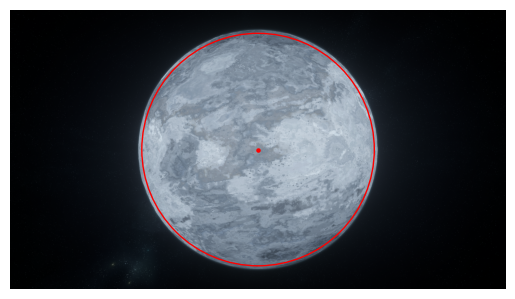

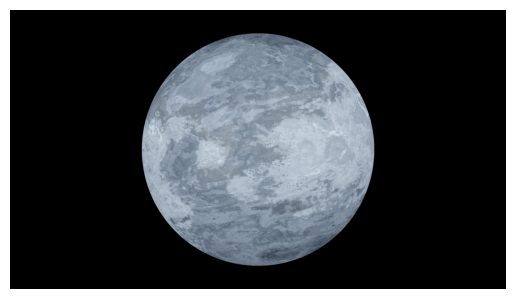

In [2]:
# Read the image & metadata
img5, img5Meta = ld.readImg(PATH, "Cellin_5")

ld.showImg(img5)
ld.printMeta(img5Meta)
ld.showImgUseArea(img5, img5Meta)
img5_cropped = ld.keepUsePixels(img5, img5Meta)
ld.showImg(img5)


# Test output
A test map output with desired dimensions, and a coordinate grid with projected OM points

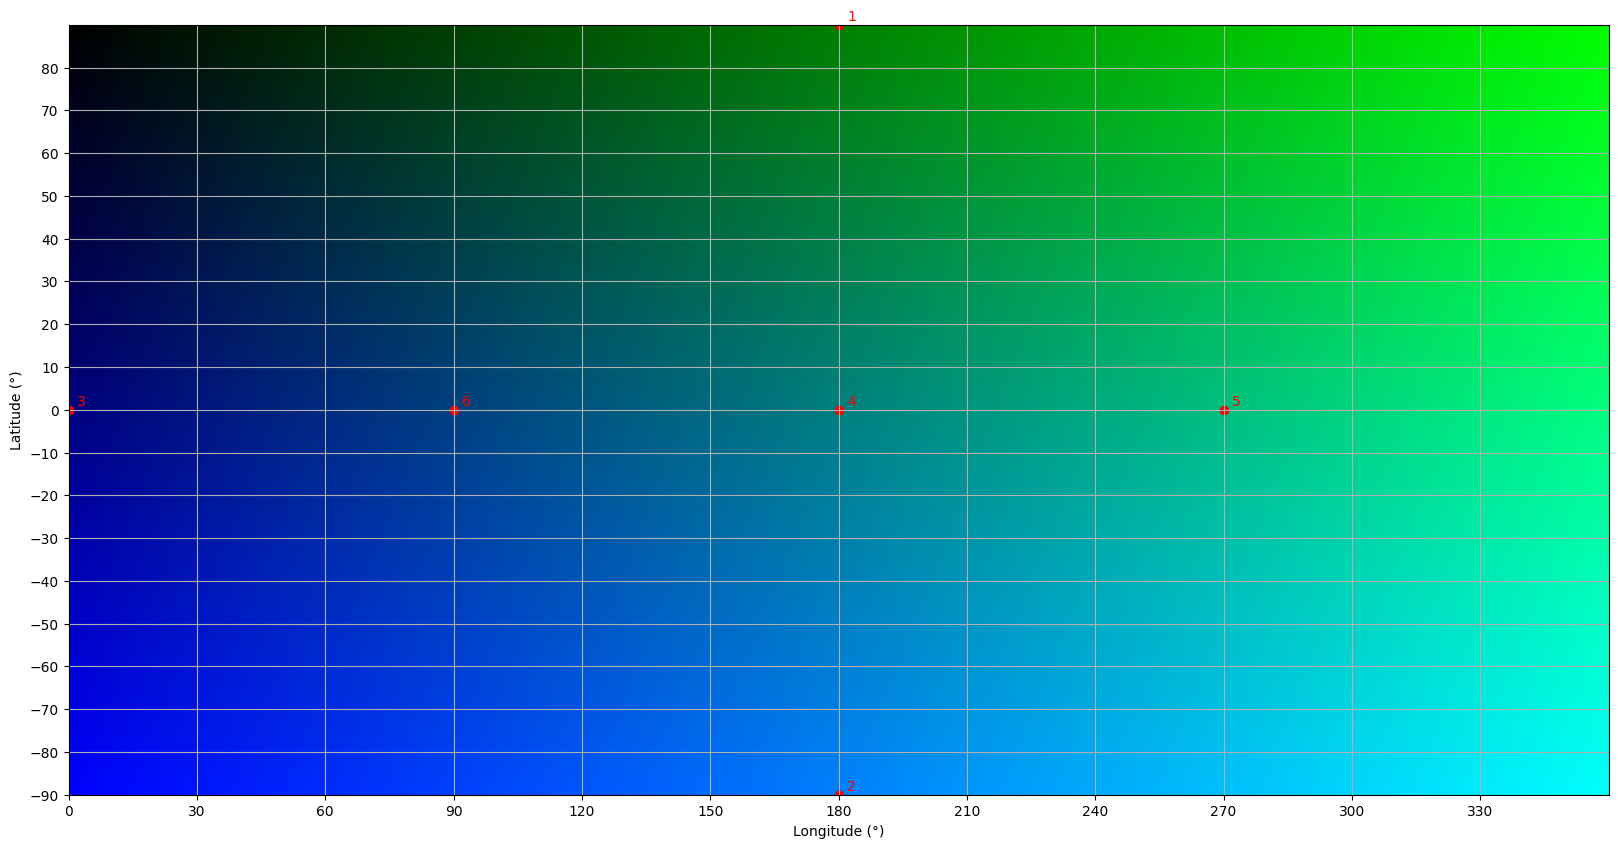

In [3]:
testImg = [[[0, x / OUTPUT_IMG_SIZE[0], y / OUTPUT_IMG_SIZE[1]] for x in range(OUTPUT_IMG_SIZE[0])] for y in range(OUTPUT_IMG_SIZE[1])]
drawMapGrid(testImg)


# Quadrilateral location
Compute the camera location with four distances to four known points.

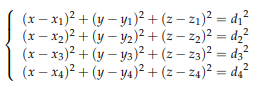

In [4]:
def quadrilateral(x1y1z1, d1, x2y2z2, d2, x3y3z3, d3, x4y4z4, d4):
    x1, y1, z1 = x1y1z1
    x2, y2, z2 = x2y2z2
    x3, y3, z3 = x3y3z3
    x4, y4, z4 = x4y4z4
    A11 = 2 * (x1 - x2)
    A12 = 2 * (y1 - y2)
    A13 = 2 * (z1 - z2)
    A21 = 2 * (x1 - x3)
    A22 = 2 * (y1 - y3)
    A23 = 2 * (z1 - z3)
    A31 = 2 * (x1 - x4)
    A32 = 2 * (y1 - y4)
    A33 = 2 * (z1 - z4)
    temp1 = d1**2 - x1**2 - y1**2 - z1**2
    b1 = d2**2 - x2**2 - y2**2 - z2**2 - temp1
    b2 = d3**2 - x3**2 - y3**2 - z3**2 - temp1
    b3 = d4**2 - x4**2 - y4**2 - z4**2 - temp1
    A = np.array([[A11, A12, A13], 
                     [A21, A22, A23], 
                     [A31, A32, A33]])
    b = np.array([[b1],
                     [b2],
                     [b3]])
    AInv = np.linalg.inv(A)
    result = AInv.dot(b)
    return result[0, 0], result[1, 0], result[2, 0]


Image shot at: 
(-327.78267271962784, 305.52303484613566, -8.926193861193727)


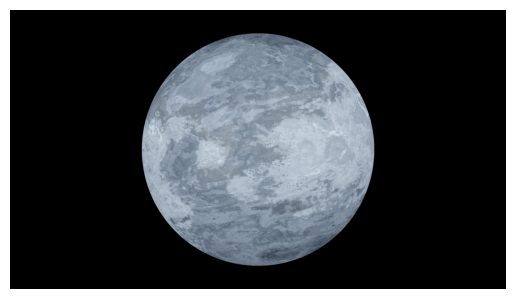

In [5]:
cam5pos = quadrilateral([0, 0, 0], 448.2, OM[1], 593.7, OM[3], 336.4, OM[6], 310.2)
print("Image shot at: ")
print(cam5pos)
plt.imshow(img5_cropped)
plt.axis('off')  # Turn off axis
plt.show()


Put points in model. The test camera location seems correct.

https://www.geogebra.org/calculator/hrqzetby


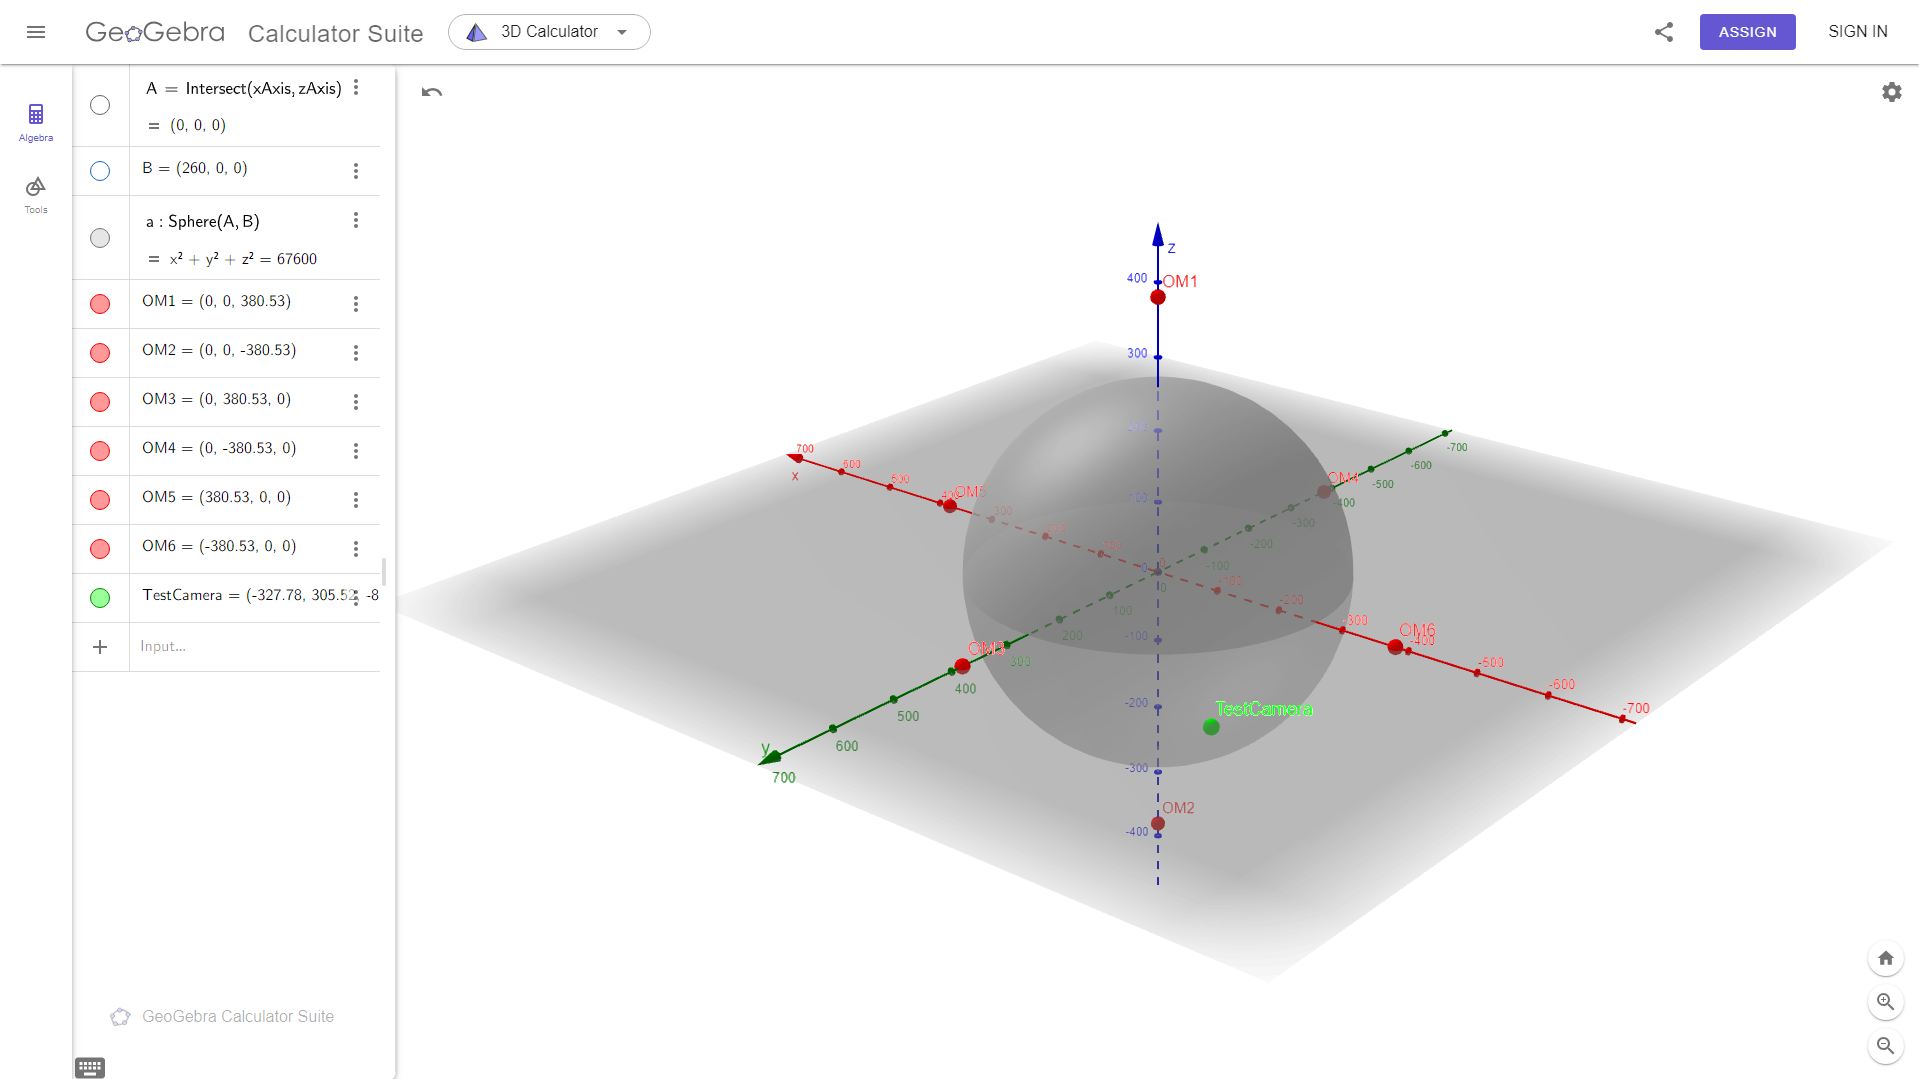

### Project Camera Orbital Position to the ground coordinate system

In [6]:
import math
def projectToGround(orbitalPos):
    x, y, z = orbitalPos
    long = math.atan(-x / y) * 180 / math.pi
    xydis = (x**2 + y**2) ** 0.5
    la = math.atan(z / xydis) * 180 / math.pi
    return [long, la]

Projected to ground at: 
[47.013022261389104, -1.1412085247938502]


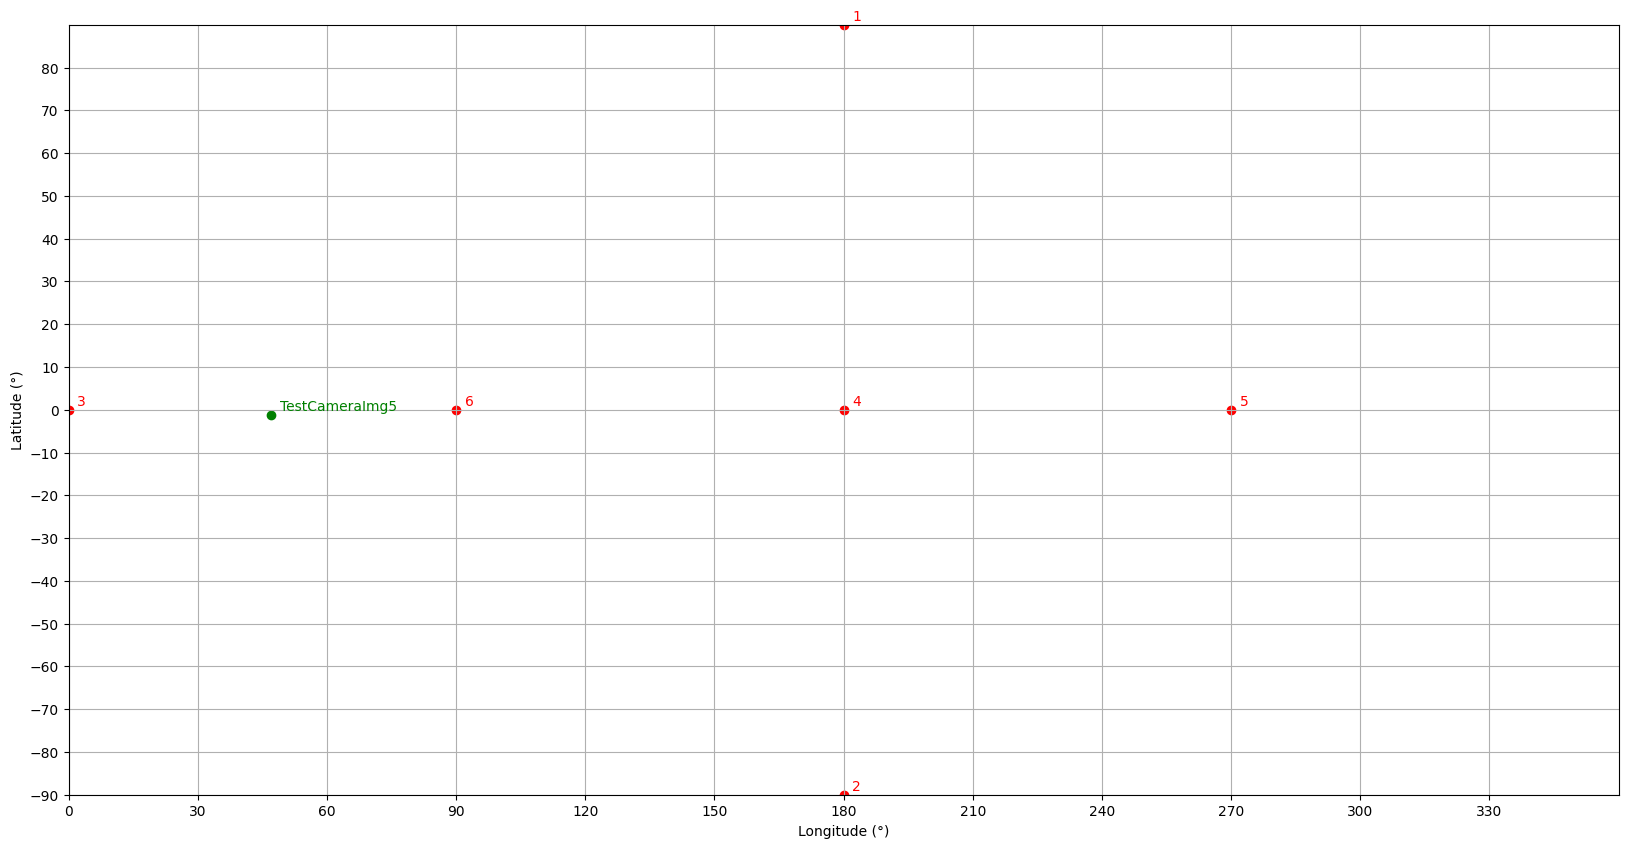

In [7]:
cam5longla = projectToGround(cam5pos)
print("Projected to ground at: ")
print(cam5longla)

drawMapGrid(None, [cam5longla], ["TestCameraImg5"])

# Single Image Projection
Map a single image to the longitude-latitude grid system.

Assume the location and rotation are known.

In [8]:
def longlaToInputImgUV(longla, inputImg, inputFov, inputCenterLongLa, camPos):
    inputUMax = inputImg.shape[1]
    inputVMax = inputImg.shape[0]
    inputCenterU = inputUMax / 2
    inputCenterV = inputVMax / 2
    inputCenterLong = inputCenterLongLa[0]
    inputCenterLati = inputCenterLongLa[1]
    localLong = longla[0] - inputCenterLong
    localLati = longla[1] - inputCenterLati
    # Max localLong & La: the contact point between the sphere and tangent line from camera.
    maxLocalLongLa = math.acos(PLANET_RADIUS / np.linalg.norm(camPos)) / math.pi * 180
    # Stop calculate if localLong and localLati is outside the horizon/contact circle
    if np.linalg.norm([localLong, localLati]) > maxLocalLongLa: return None, None
    # Calculate x, y, z from localLong and localLati relatives to camera's coordspace: 
    # x: image plane x, 
    # y: image plane y, 
    # z: image normal, centered at planet's center, towards the image
    localX = PLANET_RADIUS * math.cos(localLati * math.pi / 180) * math.sin(localLong * math.pi / 180)
    localZ = PLANET_RADIUS * math.cos(localLati * math.pi / 180) * math.cos(localLong * math.pi / 180)
    localY = PLANET_RADIUS * math.sin(localLati * math.pi / 180)
    
    focal = inputUMax / 2 / math.tan(inputFov / 2 * math.pi / 180)
    
    imgU = inputCenterU + focal / (abs(np.linalg.norm(camPos)) - localZ) * localX
    imgV = inputCenterV + focal / (abs(np.linalg.norm(camPos)) - localZ) * localY
    return round(imgU), round(imgV)

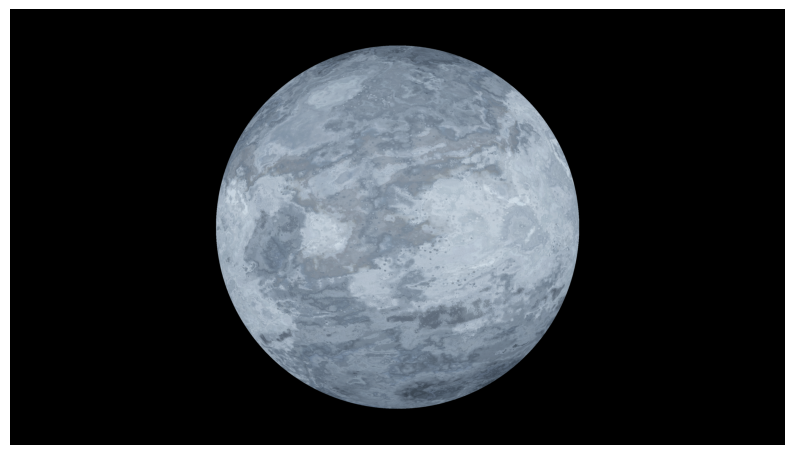

In [9]:
plt.figure(figsize=(10, 20))     
plt.imshow(img5_cropped)
plt.axis('off')  # Turn off axis
plt.show()

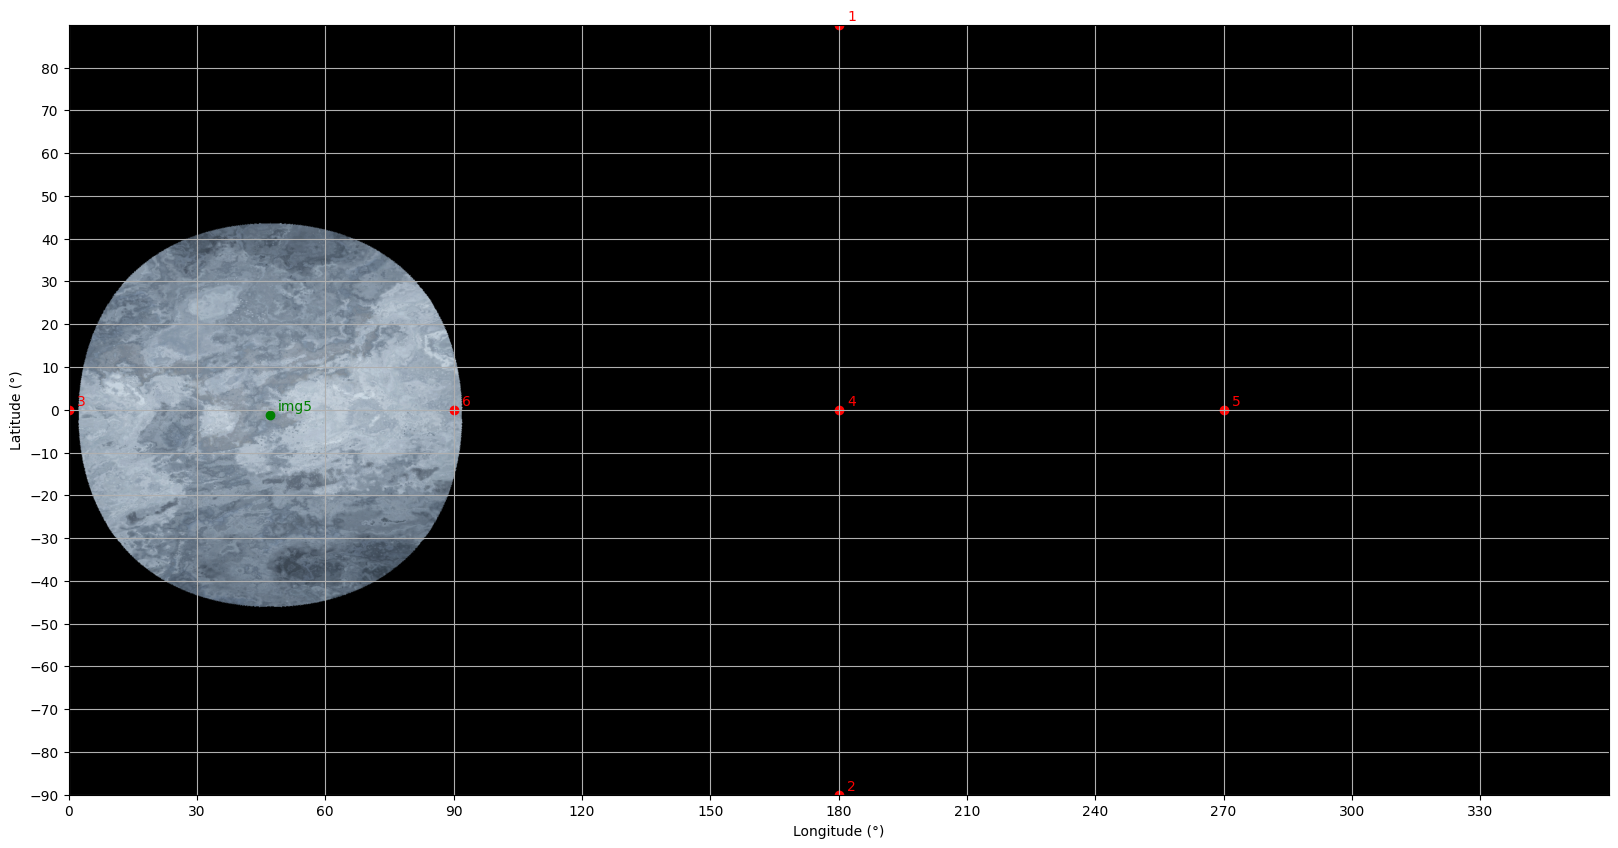

In [10]:
testMap = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))
for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longlaToInputImgUV([lo, la], img5_cropped, img5Meta["fovU"], cam5longla, cam5pos)
        if uInput is None or not (0 <= uInput < img5_cropped.shape[1] and 0 <= vInput < img5_cropped.shape[0]): 
            testMap[v, u] = [0, 0, 0]
            continue
        testMap[v, u] = img5_cropped[-vInput, uInput]

drawMapGrid(testMap, [cam5longla], ["img5"])

# Initial Exploration: Direct map with known location and rotation
Assume both img5 and img6's location and rotation are known and accurate.  
Location: using metadata.  
Rotation: image center/ camera center directly pointing to sphere's center. camera's up is aligned with north pole (OM1).


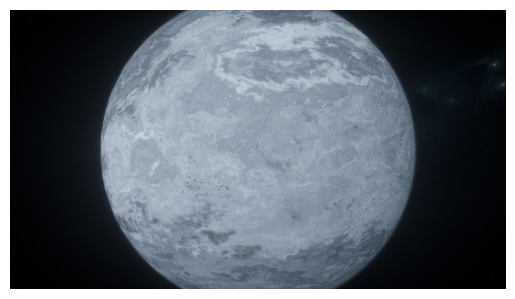

{
    "dim": [
        3840,
        2160
    ],
    "distance": {
        "om1": null,
        "om2": null,
        "om3": null,
        "om4": null,
        "om5": null,
        "om6": 0,
        "plt": null
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        1920,
        1080
    ],
    "useRadius": 1200
}


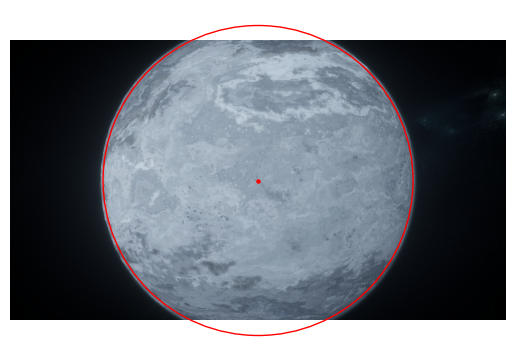

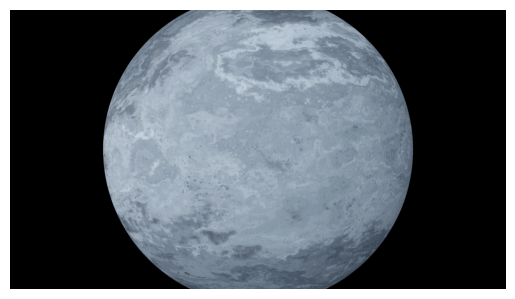

In [11]:
img6, img6Meta = ld.readImg(PATH, "Cellin_6")

ld.showImg(img6)
ld.printMeta(img6Meta)
ld.showImgUseArea(img6, img6Meta)
img6_cropped = ld.keepUsePixels(img6, img6Meta)
ld.showImg(img6)

Camera position is known: at OM6

In [12]:
cam6longla = [90, 0]
cam6pos = OM[6]

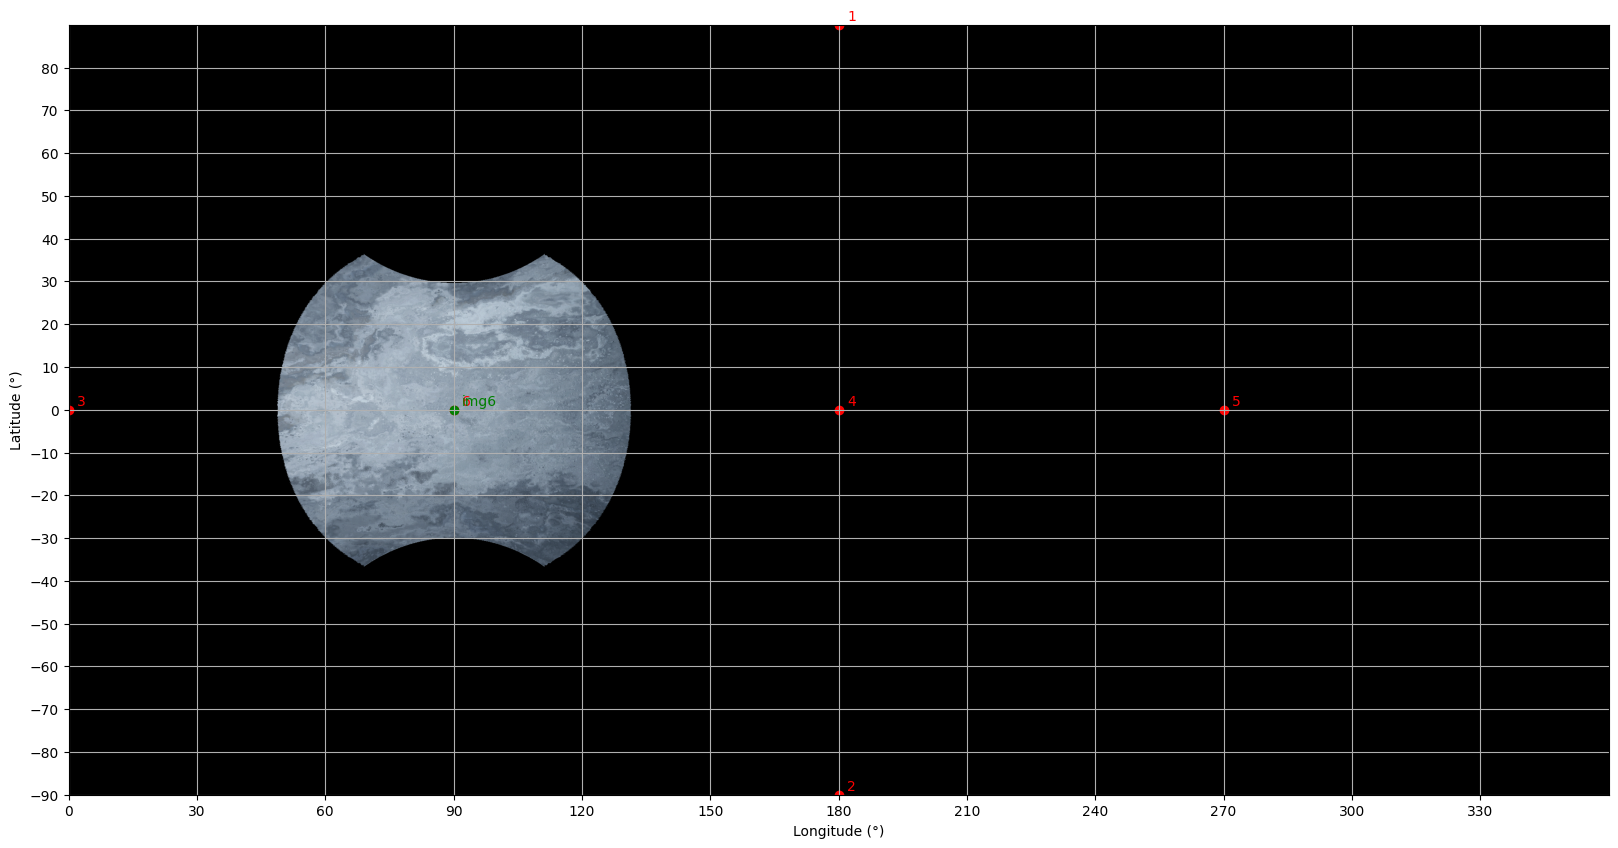

In [13]:
testMap2 = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longlaToInputImgUV([lo, la], img6_cropped, img6Meta["fovU"], cam6longla, cam6pos)
        if uInput is None or not (0 <= uInput < img6_cropped.shape[1] and 0 <= vInput < img6_cropped.shape[0]): 
            testMap2[v, u] = [0, 0, 0]
            continue
        testMap2[v, u] = img6_cropped[-vInput, uInput]

drawMapGrid(testMap2, [cam6longla], ["img6"])

### Combine 2 maps (average)

In [14]:
combineMap = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        if (testMap[v,u] != [0, 0, 0]).all() and (testMap2[v,u] != [0, 0, 0]).all():
            combineMap[v,u] = (testMap[v,u] + testMap2[v,u]) / 2
        else:
            combineMap[v,u] = (testMap[v,u] + testMap2[v,u])

IMG 5: shot at (-327.78267271962784, 305.52303484613566, -8.926193861193727)


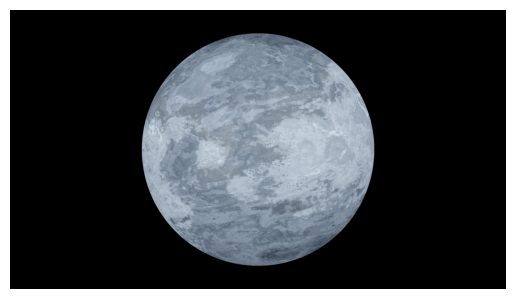

IMG 6: shot at [-380.53, 0, 0]


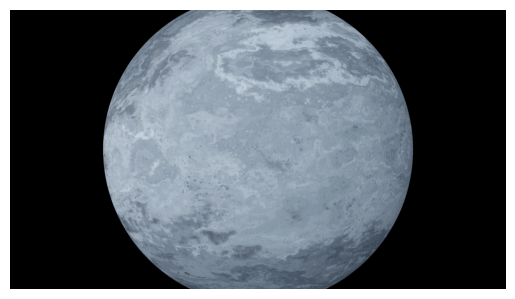

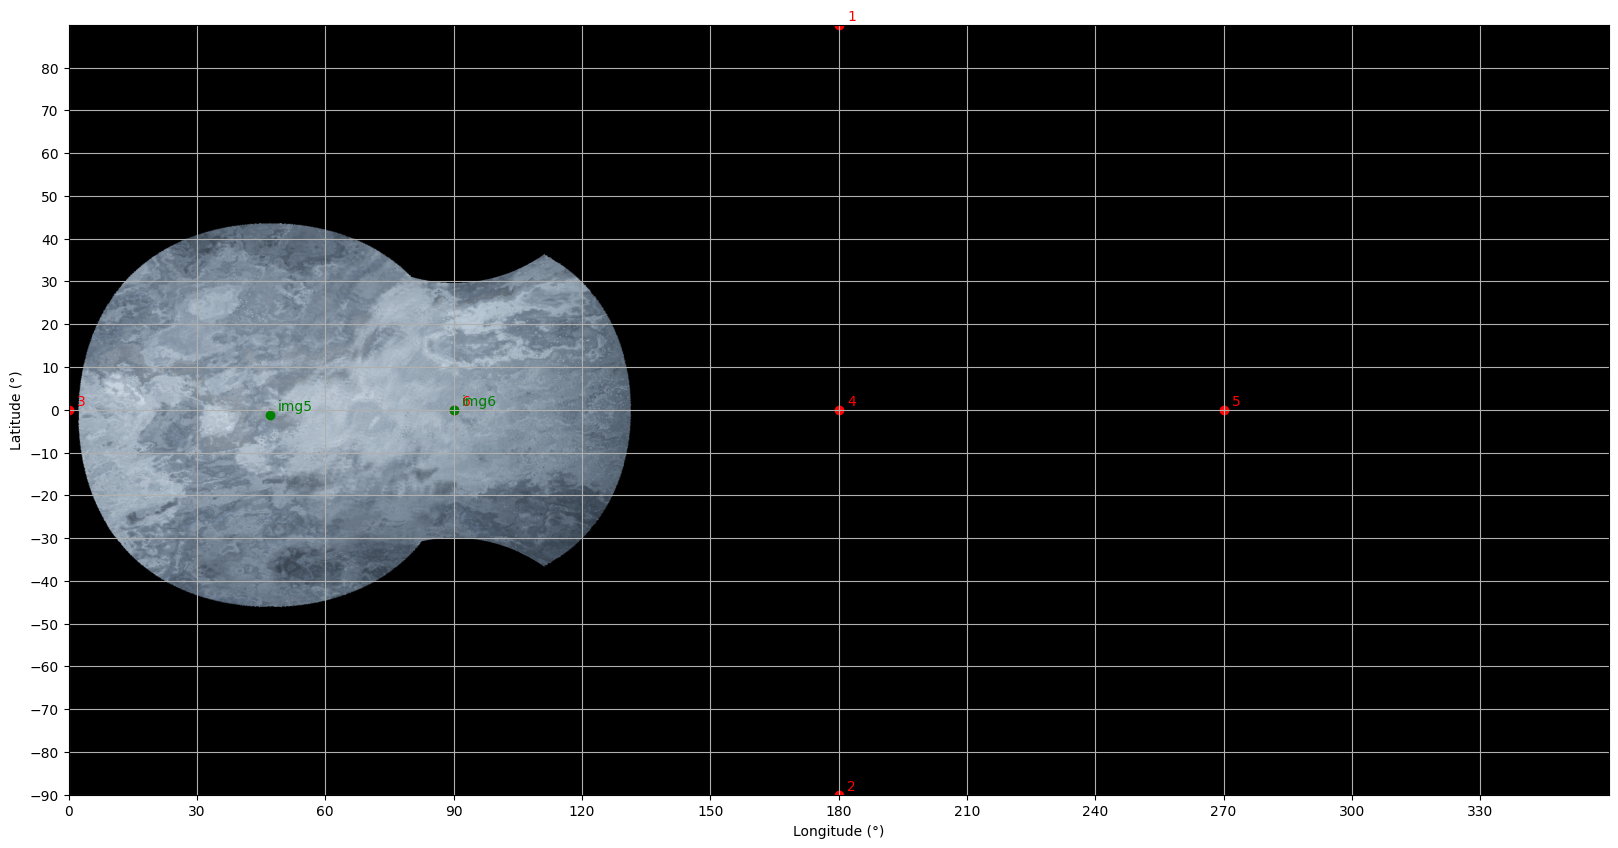

In [15]:
print("IMG 5: shot at {}".format(cam5pos))
ld.showImg(img5)
print("IMG 6: shot at {}".format(cam6pos))
ld.showImg(img6)
drawMapGrid(combineMap, [cam5longla, cam6longla], ["img5", "img6"])

The overlapped map shows the direct mappings are fairly accurate. But still has some mismatch.   
The mismatch may mainly caused by the rotation error, and minorly caused by position error.

# Two-View Stereo
Synthesize img5 and img6 using correspondence points to calibrate.

# Multi Image Projection
Using method "Structure from motion".

https://en.wikipedia.org/wiki/Structure_from_motion

Possible application for reference: https://www.capturingreality.com/realitycapture-13